In [2]:
import torch
import torch.nn as nn

In [3]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_length" : 1024,
    "emb_dim" : 768,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

Placeholder GPT architecture class

In [4]:
class DummyGPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"],bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
class DummyTransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
    
    def forward(self,x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self,normalized_shape, eps=1e-5):
        super().__init__()
    
    def forward(self,x):
        return x

In [6]:
import tiktoken 
tokenizer = tiktoken.get_encoding("gpt2") 
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch = []
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [7]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(logits)
print(logits.shape)

tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
torch.Size([2, 4, 50257])


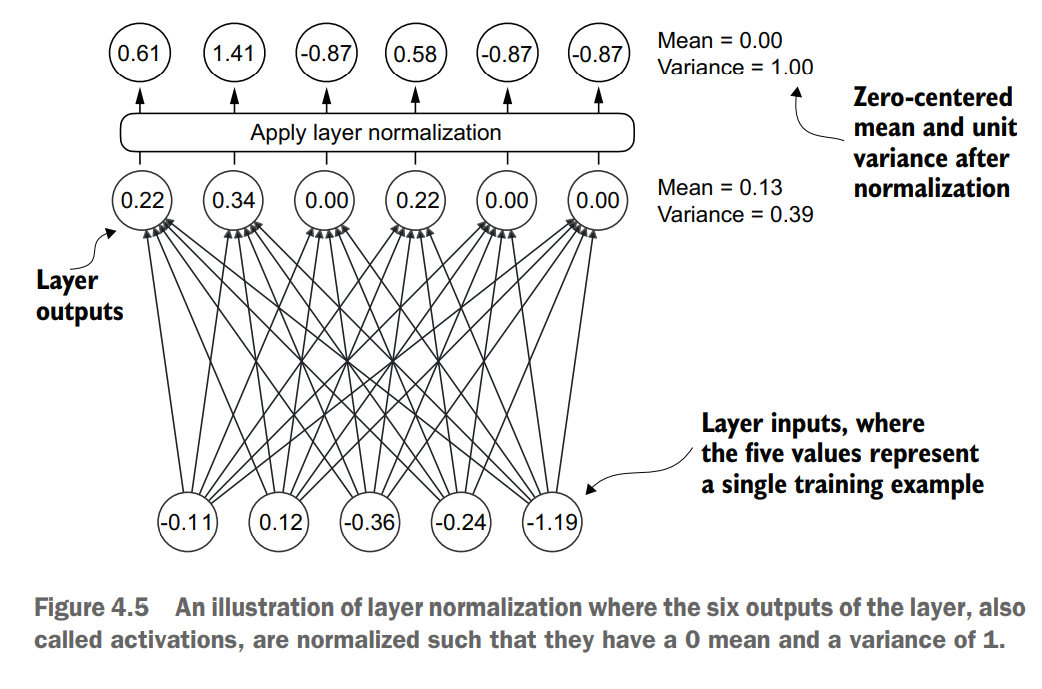

In [8]:
# Implementing above illustration

torch.manual_seed(123)
batch_example = torch.rand(2,5)
layer = nn.Sequential(nn.Linear(5,6),nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)


In [14]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean: ", mean)
print("Variance: ", var)

Mean:  tensor([[0.2432],
        [0.1928]], grad_fn=<MeanBackward1>)
Variance:  tensor([[0.0799],
        [0.0670]], grad_fn=<VarBackward0>)


In [15]:
out_norm = (out-mean)/torch.sqrt(var)
mean = out_norm.mean(dim=-1,keepdim=True)
var = out_norm.var(dim=-1,keepdim=True)
torch.set_printoptions(sci_mode=False)
print("New Mean", mean)
print("New Variance", var)
print(out_norm)

New Mean tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
New Variance tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)
tensor([[-0.8603, -0.8603,  0.5869,  1.4698,  0.5242, -0.8603],
        [-0.7450, -0.7450, -0.0102,  0.4844,  1.7608, -0.7450]],
       grad_fn=<DivBackward0>)


Creating Layer Normalization class

In [16]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased = False)
        x_norm = (x-mean) / torch.sqrt(var+self.eps)
        return x_norm * self.scale + self.shift

In [18]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.9998],
        [0.9999]], grad_fn=<VarBackward0>)


Implementing the GELU activation function

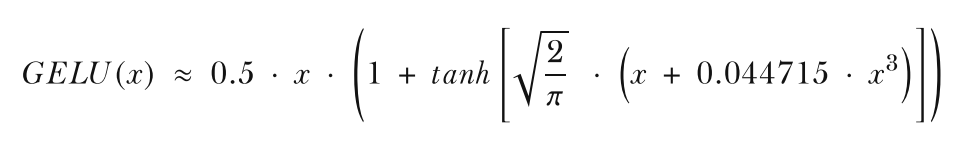

In [19]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x,3))))

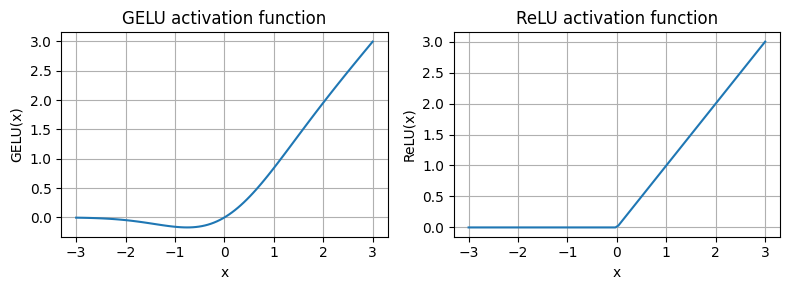

In [20]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
 plt.subplot(1, 2, i)
 plt.plot(x, y)
 plt.title(f"{label} activation function")
 plt.xlabel("x")
 plt.ylabel(f"{label}(x)")
 plt.grid(True)
plt.tight_layout()
plt.show()

Create feed forward neural network module

In [21]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"])
            )
        
    def forward(self,x):
        return self.layers(x)

In [24]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)
out = ffn(x)
print(out)

tensor([[[-0.0675, -0.0875, -0.0711,  ...,  0.0803, -0.0491, -0.0258],
         [-0.0533, -0.0041, -0.0577,  ...,  0.1279, -0.1916,  0.0076],
         [-0.0722, -0.0245, -0.0235,  ...,  0.2920, -0.0916, -0.0070]],

        [[-0.0776, -0.0207, -0.1294,  ...,  0.2189, -0.1656, -0.0250],
         [-0.1213, -0.0235,  0.0499,  ...,  0.2044, -0.0594,  0.0542],
         [-0.0424,  0.0608,  0.0228,  ...,  0.2314, -0.1501,  0.0843]]],
       grad_fn=<ViewBackward0>)


In [25]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers =  nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layers in self.layers:
            layer_output = layers(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [29]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut =  ExampleDeepNeuralNetwork(layer_sizes, use_shortcut =False)

In [32]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output,target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [33]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.0004034718149341643
layers.1.0.weight has gradient mean of 0.0002402232203166932
layers.2.0.weight has gradient mean of 0.0014304084470495582
layers.3.0.weight has gradient mean of 0.0027977479621767998
layers.4.0.weight has gradient mean of 0.01009929459542036


In [34]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
 layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694102346897125
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472
